In [1]:
import enum
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
from matplotlib.cm import ScalarMappable
import eurostat

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath(".."))

from data_analysis.eurostat_population_utils import get_eurostat_population_data 
from data_analysis.eurostat_crf_utils import *
from data_analysis.eurostat_geo import *

TOHLE TVOŘÍM: https://faktaoklimatu.cz/infografiky/emise-eu-na-osobu

## 1) Set year and load data

In [2]:
# Year we want to visualize
YEAR = 2016

In [3]:
# fetch emission data using 'get_eurostat_crf_data_for_code' function
df_emis = get_eurostat_crf_data_for_code(
    "TOTX4_MEMONIA", YEAR).rename(columns={'value': 'MtCO2eq'})

In [4]:
# fetch demographic data using 'get_eurostat_population_data' function
df_demo = get_eurostat_population_data(
    YEAR).rename(columns={'value': 'population'})

In [5]:
# Merge the data frames on select only EU27 countries.
df = df_emis.merge(df_demo, on='geo')
df = df.loc[df.index.isin([geo.value for geo in eu27_geo_dict.keys()])]
df['country'] = eu27_geo_dict.values()

In [6]:
df['population_(mil)'] = (df['population'] / 1000000)
df['em_per_capita'] = (df['MtCO2eq'] * 1000000) / df['population']
df['total'] = (df['population_(mil)'] * df['em_per_capita'])

In [7]:
df.head()

,MtCO2eq,population,country,population_(mil),em_per_capita,total
geo,,,,,,
AT,82.20543,8700471.0,Rakousko,8.700471,9.448388,82.20543
BE,121.93794,11311117.0,Belgie,11.311117,10.780362,121.93794
BG,58.57936,7153784.0,Bulharsko,7.153784,8.188584,58.57936
CY,9.66393,848319.0,Kypr,0.848319,11.391858,9.66393
CZ,132.54270,10553843.0,Česko,10.553843,12.558714,132.54270


### TODO
- popisky os grafu: CO2 - tu '2' do nižšího indexu
- popisné texty pod graf

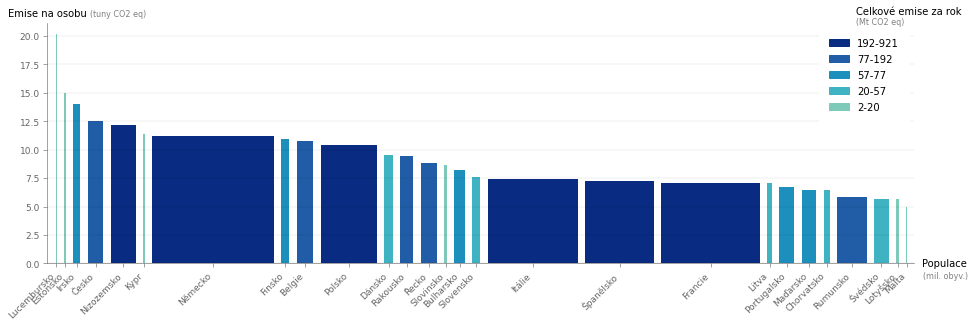

In [33]:
# Set colors and color intervals
color_intervals = [20, 40, 60, 80] # Change the color groups in the chart by changing 'intervals' here
colors = ['#3fb3c2', '#1c8fbd', '#215ca6', '#0a2b82', '#7dcab8']

# Sort the DataFrame based on the 'em_per_capita' column in descending order
df_sorted = df.sort_values(by='em_per_capita', ascending = False)

# Calculate the widths for each bar based on the sorted total values
widths = df_sorted['population_(mil)'].values.tolist()

# COMPUTE POSITIONS ON X AX
# Set the gap between bars
gap = 5
# Each position is the previous one + half of the widths of the neighbouring columns + the gap
positions = [widths[0]/2 + gap]
for i in range(len(widths) - 1):
    positions.append(positions[i] + widths[i]/2 + widths[i+1]/2 + gap)
# Find the minimum value in the list
min_value = min(positions)
# Subtract the minimum value from each element in the list
positions = [value - min_value for value in positions]

# CREATE COLOR INTERVALS  
# Create df_sorted_total which is sorted by 'total' values to correctly add the colors
df_sorted_total = df.sort_values(by='total', ascending = False)

# Determine the color for each 'total' value
color_mapping = np.digitize(df_sorted_total['total'], bins=np.percentile(df_sorted_total['total'], color_intervals))

# Create a DataFrame for colors
df_for_colors = pd.DataFrame({'total': df_sorted_total['total'], 'colors': [colors[i-1] for i in color_mapping]}) 
df_sorted['colors'] = df_for_colors['colors']   
        
# SET CHART PROPRETIES 
# Set the size of the chart frame
plt.figure(figsize=(14,4))

# Create a bar chart with sorted, spaced, and no overlap bars
bars = plt.bar(positions, df_sorted['em_per_capita'], width=widths, color=df_sorted['colors'], edgecolor=None)

# Adding labels and title
plt.xlabel('Populace')
plt.ylabel('Emise na osobu', rotation=0)
plt.title('')

# Set x-axis ticks to the positions of the bars
plt.xticks(positions, df_sorted['country'], rotation=45, ha='right')  

# Remove vertical grid lines
plt.gca().xaxis.grid(False)

# Move ax x label
plt.gca().xaxis.set_label_coords(1.035, 0.02)
plt.gca().yaxis.set_label_coords(0.0, 1.02)

# Add texts
plt.text(23,21.7, f'(tuny CO2 eq)', size = 8, color ='grey')
plt.text(585,-1.3, f'(mil. obyv.)', size = 8, color ='grey')
plt.text(540,21.9, f'Celkové emise za rok', size = 10, color ='black')
plt.text(540,21, f'(Mt CO2 eq)', size = 8, color ='grey')

# ADD LEGEND
# Define intervals based on the array
array = list(np.percentile(df_sorted_total['total'], color_intervals))
intervals = [min(df_sorted_total['total'])] + array + [max(df_sorted_total['total'])]
intervals = [[intervals[i], intervals[i+1]] for i in range(len(intervals)-1)]

# Create proxy artists and labels for legend
num_intervals = 5
patches = [mpatches.Patch(color=colors[i-1], alpha=1, label=f'{intervals[i][0]:.0f}-{intervals[i][1]:.0f}') for i in range(num_intervals)]
patches = patches[::-1] # sort descending

# Add the legend with intervals
plt.legend(handles=patches, facecolor='white')

# adjust plot edge gaps
plt.xlim(-6, positions[-1]+5)

# DISPLAY THE CHART
plt.show()

## X) Texts 

### text todoes
- průměrné emise na os v EU: rok a světový průmě emisí na os: rok - neshodné roky.
- mám do toho textu dávat ty <sub2/sub>?
- to číslo pro Lucemburský emise z dopravy je nějaký nízký (o 13% nižší než má bejt). Nemá tam být něco víc než jen CRF1A3 sektor? (https://docs.google.com/spreadsheets/d/1KNL5d1CwLsLc8INquN7z5ABdr52APEsDjEsUcYGh_Mk/edit#gid=525565541)

In [9]:
df.head(1)

,MtCO2eq,population,country,population_(mil),em_per_capita,total
geo,,,,,,
AT,82.20543,8700471.0,Rakousko,8.700471,9.448388,82.20543


In [10]:
df_sorted.head(1)

,MtCO2eq,population,country,population_(mil),em_per_capita,total,colors
geo,,,,,,,
LU,11.612,576249.0,Lucembursko,0.576249,20.151011,11.612,#7dcab8


### Text variables 

In [11]:
def percentage(part, whole):
    return (part / whole) * 100

In [12]:
# word emission 2015 (ZDROJ: emise svět FoK, https://faktaoklimatu.cz/datasety/emise-svet)
word_year = 2015
word_emiss = 46910 # Mt CO2eq
word_popul = 7187923043
em_per_cap_word =  (word_emiss/word_popul)*1000000

In [13]:
# Find the country which creates most CO2eq emissions in EU
df_sorted_MtCO2eq = df.sort_values(by='MtCO2eq', ascending = False)
country_most_MtCO2eq = df_sorted_MtCO2eq.iloc[0]['country']

# Find the country whith the biggest population
df_sorted_population = df.sort_values(by='population', ascending = False)
country_top_popul = df_sorted_population.iloc[0]['country']

# Find top 4 countries by emission per capita and the values
    # 1
country_first_em_per_capita = df_sorted.iloc[0]['country'] # country
top_em_per_capita_value = df_sorted.iloc[0]['em_per_capita'] # value
    # 2
country_second_em_per_capita = df_sorted.iloc[1]['country'] # country
second_em_per_capita_value = df_sorted.iloc[1]['em_per_capita'] # value
    # 3
country_third_em_per_capita = df_sorted.iloc[2]['country'] # country
third_em_per_capita_value = df_sorted.iloc[2]['em_per_capita'] # value
    # 4
country_fourth_em_per_capita = df_sorted.iloc[3]['country'] # country
fourth_em_per_capita_value = df_sorted.iloc[3]['em_per_capita'] # value

# Find bottom 2 countries by emission per capita and the values
df_sorted_reversed = df_sorted.iloc[::-1]
    # 1
country_last_em_per_capita = df_sorted_reversed.iloc[0]['country'] # country
last_em_per_capita_value = df_sorted.iloc[0]['em_per_capita'] # value

# COMPUTE TEXT VARIABLES
# emissions per person EU in tons
em_per_cap_EU = (sum(df_sorted['total'])/sum(df_sorted['population']))*1000000

# If each person in the Word has the emission production of average EU citizen
em_word_if = (em_per_cap_EU * word_popul)/1000000
word_perc_if_EU_production_per_cap = percentage(em_word_if, word_emiss) - 100

In [14]:
# LUXEMBOURG
# Load transport emission data
df_emis_transport = get_eurostat_crf_data_for_code(
    "CRF1A3", YEAR).rename(columns={'value': 'MtCO2eq'})

# count transport emission portion
LU_whole = df_sorted.loc['LU', 'MtCO2eq']
LU_transport_emiss = df_emis_transport.loc['LU', 'MtCO2eq']
LU_transport_em_portion = percentage(LU_transport_emiss,LU_whole)

#### Fact check statements

Update the statements in text section below if they are no more correct.

In [15]:
# Is Germany still the biggest state in EU? (population)
print(f'''
Which EU state has the biggest population? It is {country_top_popul}.
''')

# Is Germany still the biggest absolute emmitent?
print(f'''
Which EU state is the biggest absolute emitent? It is {country_most_MtCO2eq }.
''')

# Is Luxembourg still the biggest emmitent per capita?
print(f'''
Which EU state is the biggest emmitent per capita? It is {country_first_em_per_capita}.
''')

# Is Estonia still the second biggest emmitent per capita?
print(f'''
Which EU state is the second biggest emmitent per capita? It is {country_second_em_per_capita}.
''')

# Is Ireland still the third biggest emmitent per capita?
print(f'''
Which EU state is the third biggest emmitent per capita? It is {country_third_em_per_capita}.
''')

# Is Czechia still the fourth biggest emmitent per capita?
print(f'''
Which EU state is the fourth biggest emmitent per capita? It is {country_fourth_em_per_capita}.
''')


Which EU state has the biggest population? It is Německo.


Which EU state is the biggest absolute emitent? It is Německo.


Which EU state is the biggest emmitent per capita? It is Lucembursko.


Which EU state is the second biggest emmitent per capita? It is Estonsko.


Which EU state is the third biggest emmitent per capita? It is Irsko.


Which EU state is the fourth biggest emmitent per capita? It is Česko.



## Create texts 

In [16]:
# Print backing texts
print(f'''
Průměrné emise na osobu v Evropské unii za rok {YEAR} jsou {em_per_cap_EU:.1f} tun CO2eq. Oproti tomu světový průměr emisí na osobu za rok {word_year} je {em_per_cap_word:.2f} tun CO2eq. Pokud by každý člověk na Zemi vypouštěl tolik emisí jako průměrný obyvatel Evropské unie, vzrostly by celosvětové emise o {word_perc_if_EU_production_per_cap:.0f} %. Srovnání světových regionů a vybraných států v obdobném formátu ukazuje infografika [Emise světových regionů přepočtené na osobu](https://faktaoklimatu.cz/infografiky/emise-svet-na-osobu).
''')

print(f'''
Největším producentem skleníkových plynů v Evropské unii je v absolutním srovnání {country_most_MtCO2eq}, které je také nejlidnatějším státem EU.
''') 

print(f'''
V přepočtu na obyvatele vypouští nejvíce skleníkových plynů {country_first_em_per_capita} ({top_em_per_capita_value:.0f}t CO2eq ročně), kde {LU_transport_em_portion:.1f} % emisí pochází z dopravy. Dle platformy [Votum Klima](https://today.rtl.lu/news/luxembourg/a/1184731.html) je to způsobené nafto-benzínovým turismem. Druhé {country_second_em_per_capita} ({second_em_per_capita_value:.1f}t CO2eq ročně) a čtvrté {country_fourth_em_per_capita} ({fourth_em_per_capita_value:.1f}t CO2eq ročně) a třetí {country_third_em_per_capita} ({third_em_per_capita_value:.1f}t CO2eq ročně)XXXXXXXXX. Detailnější analýzu emisí podle jednotlivých sektorů lze nalézt ve [zpracovaném datasetu](https://docs.google.com/spreadsheets/d/1KNL5d1CwLsLc8INquN7z5ABdr52APEsDjEsUcYGh_Mk/edit#gid=979818322). 
''')

print(f'''
blablabla
''')


Průměrné emise na osobu v Evropské unii za rok 2016 jsou 8.8 tun CO2eq. Oproti tomu světový průměr emisí na osobu za rok 2015 je 6.53 tun CO2eq. Pokud by každý člověk na Zemi vypouštěl tolik emisí jako průměrný obyvatel Evropské unie, vzrostly by celosvětové emise o 35 %. Srovnání světových regionů a vybraných států v obdobném formátu ukazuje infografika [Emise světových regionů přepočtené na osobu](https://faktaoklimatu.cz/infografiky/emise-svet-na-osobu).


Největším producentem skleníkových plynů v Evropské unii je v absolutním srovnání Německo, které je také nejlidnatějším státem EU.


V přepočtu na obyvatele vypouští nejvíce skleníkových plynů Lucembursko (20t CO2eq ročně), kde 47.3 % emisí pochází z dopravy. Dle platformy [Votum Klima](https://today.rtl.lu/news/luxembourg/a/1184731.html) je to způsobené nafto-benzínovým turismem. Druhé Estonsko (14.9t CO2eq ročně) a čtvrté Česko (12.6t CO2eq ročně) a třetí Irsko (14.0t CO2eq ročně)XXXXXXXXX. Detailnější analýzu emisí podle jedno

### vzor
    Průměrné emise na osobu v Evropské unii jsou 8,7 tun CO2eq. Oproti tomu světový průměr emisí na osobu je 6,51 tun CO2eq na rok. Pokud by každý člověk na zemi vypouštěl tolik emisí jako průměrný obyvatel Evropské unie, vzrostly by celosvětové emise o více než 30 %. Srovnání světových regionů a vybraných států v obdobném formátu ukazuje infografika Emise světových regionů přepočtené na osobu.
    
    Největším producentem skleníkových plynů v Evropské unii je v absolutním srovnání Německo, které je zároveň také nejlidnatějším státem unie.
    
    V přepočtu na obyvatele vypouští nejvíce skleníkových plynů Lucembursko (20 t CO2eq ročně), kde více než 60 % emisí pochází z dopravy, dle platformy Votum Klima je to způsobené nafto-benzínovým turismem. Druhé Estonsko (15 t CO2eq) a čtvrtá Česká republika (12,4 CO2eq) mají vysoké emise kvůli energetickému mixu založenému na uhlí a třetí Irsko (13,6 t CO2eq) kvůli zemědělství. Detailnější analýzu emisí podle jednotlivých sektorů lze nalézt ve zpracovaném datasetu.
    
    Naopak nejnižší emise na osobu má z Evropských států Malta (5,1 t CO2eq), následovaná Švédskem (5,6 t CO2eq). Zároveň životní úroveň ve Švédsku je téměř o 40 % vyšší než v České republice, snižování emisí tedy nemusí být překážkou zvyšování životní úrovně obyvatel. Švédsko má zavedenou uhlíkovou daň již od roku 1991, dnes nejvyšší z celého světa – 127 $ / t CO2. Ve zprávě z roku 2019 Mezinárodní měnový fond vysvětluje, proč je uhlíková daň nejefektivnějším opatřením na snižování emisí skleníkových plynů, jak zobrazuje také související infografika o mitigačních opatřeních.
